In [1]:
import torch 
import matplotlib.pyplot as plt
from utils import * 
from mlmm import SmoothKernelMLMM
from einops import rearrange

In [2]:
# torch.set_printoptions(precision=2, sci_mode=False, linewidth=100)

In [3]:
# smooth kernel 
# l = 8
# n = 2**l - 1
# xh = torch.linspace(0, torch.pi, n+2)[1:-1]
# h = xh[0]

# # input function
# uh = torch.sin(xh)**2

# # kernel function
# gh_X, gh_Y = torch.meshgrid(xh, xh)
# Khh = torch.cos(gh_Y - gh_X)

# # # output function(numeric)
# # wh = h * Khh @ uh 

# # analytics
# wh_gt = torch.sin(xh) * 4/3

In [4]:
# singular smooth kernel 

l = 4
n = 2**l - 1
xh = torch.linspace(-1, 1, n+2)[1:-1]
h = xh[1] - xh[0]

# input function
uh = 1-xh**2

# kernel function
gh_X, gh_Y = torch.meshgrid(xh, xh)
Khh = torch.log((gh_Y - gh_X).abs()+1e-5)

# # output function(numeric)
wh = h * Khh @ uh 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
k = 2
H = 2**3*h

hs = []
for i in range(k):
    if i == 0:
        hs.append(h)
        H = h*2
    else:
        H = H*2
    hs.append(H)

Ks = []
for i in range(k):
    if i == 0:
        Ks.append(Khh)
        KHH = Khh[1::2,1::2] # inject Khh to KHH
    else:
        KHH = KHH[1::2,1::2]
    Ks.append(KHH)

us = []
for i in range(k):
    if i == 0:
        us.append(rearrange(uh, 'n -> n 1'))
        uH = restrict1d(uh[None][None])
    else:
        uH = restrict1d(uH) # restrict uh to uH 
    us.append(rearrange(uH, '1 1 n -> n 1'))

In [6]:
# coarest grid, level 1
KHH = Ks[-1]
uH = us[-1]
H = hs[-1]

Khh = Ks[-2]
uh = us[-2]
h = hs[-2]

In [7]:
wH = H * KHH @ uH

Khh_even_ = interp1d_cols(KHH[None][None])[0,0]
Khh_even = Khh[1::2]

In [73]:
m = 1
n = uH.shape[0]
idx_H = range(1, n+1)
idx_h = range(1, 2*n+1 + 1)

In [74]:
even_npad = 1-(2-m)
if even_npad > 0:
    even_nbrs = [[0,0]] * even_npad
else:
    even_nbrs = []

for I in idx_H:
    for j in idx_h:
        if abs(2*I - j) <= m:
            even_nbrs.append([I, j])

if even_npad > 0:
    even_nbrs += [[0,0]] * even_npad

even_nbrs = torch.tensor(even_nbrs)

In [75]:
idx_H = range(1, n+2)
odd_nbrs = []
for I in idx_H:
    for j in idx_h:
        if abs(2*I-1 - j) <= m:
            odd_nbrs.append([I, j])
odd_nbrs = torch.tensor(odd_nbrs)

In [76]:
even_nbrs_x, even_nbrs_y = even_nbrs[:,0]-1, even_nbrs[:,1]-1
even_nbrs_mask = even_nbrs_x>0
Khh_even_diff = Khh_even[even_nbrs_x, even_nbrs_y] - Khh_even_[even_nbrs_x, even_nbrs_y]
Khh_even_diff_chunk = rearrange(Khh_even_diff, '(I m) -> I m', m = 2*m+1, I = n)
uh_even_chunk = rearrange(uh[even_nbrs_y], '(I m) 1-> I m', m = 2*m+1, I = n)
mask_even_chunk = rearrange(even_nbrs_mask, '(I m)-> I m', m = 2*m+1, I = n)
wh_even_cor = (Khh_even_diff_chunk * uh_even_chunk * mask_even_chunk).sum(axis=1, keepdim=True)

In [77]:
wh_even = wH + wh_even_cor * h

In [78]:
h*Khh[1::2]@uh

tensor([[-2.8221],
        [-3.8192],
        [-2.8221]])

In [80]:
wH

tensor([[-4.4255],
        [-6.0244],
        [-4.4255]])

In [81]:
wh_even

tensor([[-4.4255],
        [-3.8318],
        [-2.8598]])

In [15]:
wh_odd_ = rearrange(interp1d(rearrange(wh_even, 'H 1->1 1 H')), '1 1 h->h 1')[::2]

In [38]:
even_nbrs = []
for I in idx_H:
    for j in idx_h:
        if abs(2*I - j) <= m:
            if (I == 1) & (j == 1):
                even_nbrs.append([])
            even_nbrs.append([I, j])
even_nbrs = torch.tensor(even_nbrs)

In [39]:
even_nbrs

tensor([[1, 1],
        [1, 2],
        [1, 3],
        [2, 3],
        [2, 4],
        [2, 5],
        [3, 5],
        [3, 6],
        [3, 7],
        [4, 7]])

In [37]:
odd_nbrs

[[1, 1],
 [1, 2],
 [2, 2],
 [2, 3],
 [2, 4],
 [3, 4],
 [3, 5],
 [3, 6],
 [4, 6],
 [4, 7]]

In [32]:
wh_odd_.shape

torch.Size([4, 1])

In [6]:
# for i = 2I, wh_even full calculation
wh_even = h * Khh[1::2,:] @ uh

In [7]:
# for i = 2I, wh_even_ mlmm
wH = H * KHH @ uH
Khh_even_correct = Khh[1::2,:] - interp1d_cols(KHH[None][None])[0][0]
wh_decomp = wH + h*Khh_even_correct @ uh

In [8]:
idx_h = list(range(1, n+1))
idx_H = idx_h[1::2]

In [34]:
m = 3
m2_even_nbrs = []
for i in idx_H:
    i_nbrs = []
    for j in idx_h:
        if abs(i-j) <= m:
            i_nbrs.append([i, j])
    m2_even_nbrs.append(i_nbrs)

for i_nbrs in m2_even_nbrs:
    i_nbrs = torch.tensor(i_nbrs)
    

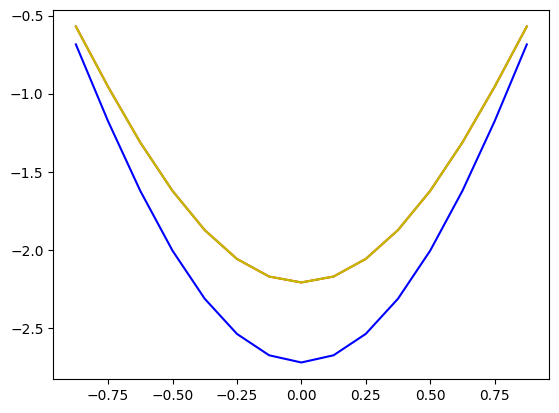

In [72]:
plt.plot(xh[1::2], wh_even, '-r')
plt.plot(xh[1::2], wH, '-b')
plt.plot(xh[1::2], wh_decomp, '-y')

In [58]:
# plt.plot(xh, wh, '-r')
# plt.plot(xh[1::2], wH, '-b')

In [25]:
# plt.plot(xh, wh_gt, '-r', label='analytics')
# plt.plot(xh, wh, '--b', label='numeric')

In [6]:
# for k in range(5):
#     wh = SmoothKernelMLMM(uh[None][None], Khh[None][None], h, k)
#     L1 = (wh[0,0] - wh_gt).abs().sum()/(n+1)
#     print(k, L1)

In [7]:
# plt.plot(xh, wh[0,0], '--r', label='mlmm')
# plt.plot(xh, wh_gt, '-b', label='analytic')
# plt.legend()

In [8]:
uh = uh[None][None]

In [9]:
L = 1
m = 1
n = 2**L + 1
I = torch.arange(1,n+1)
i = torch.arange(1,2*n+1)

j_even = I * 2 # next level even J is same as previous 2*I
i_even = I * 2

j_odd = torch.cat((torch.tensor([1]), I*2+1))

In [10]:
uH = restrict1d(uh)

In [11]:
uh_pad = F.pad(uh,(m,m,0,0,0,0),'constant',0)

In [12]:
window = torch.eye(2*m+1)
window = rearrange(window, 'm n -> m 1 n')
uh_chunk = F.conv1d(uh_pad, window)

In [13]:
uh_chunk_even = uh_chunk[:,:,1::2]

In [14]:
KHH = Khh[1::2,1::2][None][None]

In [15]:
KHh_ = interp1d_cols(KHH)

In [17]:
Khh_ = interp1d_rows(KHh_)

In [36]:
KHh = interp1d(rearrange(KHH, 'b c HI HJ -> (b HI) c HJ'))
KHh = rearrange(KHh, '(b H) c h-> b c H h', b = 1, c=1, H=3, h=7)